# Neural Network from Scratch
## Neural Network implemented from scratch using linear algebra library
## Adjustable layer count/layer size


In [1]:
%matplotlib inline
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from tqdm import trange
import numpy as np
import requests
import gzip    
import os
import hashlib

def fetch(url):
    
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch(
    "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch(
    "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch(
    "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch(
    "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [2]:
#different methods of initialising weights/biases
#gaussian works poorly for more than 2 layers.
#fan_init seems to work best for this reason
def gaussian_init(m, h):
    ret = np.random.uniform(-1., 1., size=(m, h))/np.sqrt(m*h)
    return ret.astype(np.float32)

def he_init(m, h):
    ret = np.random.randn(m,h)*np.sqrt(2/h)
    return ret.astype(np.float32)

def fan_init(m, h):
    ret = np.random.randn(m,h)*np.sqrt(12/(2*m*h))
    return ret.astype(np.float32)
#helper functions to initialise paramteres(weights and biases)
def get_layer_sizes(input_size,hidden_layers,output_size):
    layer_sizes = [input_size]+hidden_sizes+[output_size]
    return layer_sizes

def param_init(layer_sizes,layer_init):
    params=[[],[]]
    for i in range(1,len(layer_sizes)):
        params[0].append(layer_init(1,layer_sizes[i]))
        params[1].append(layer_init(layer_sizes[i-1],layer_sizes[i]))
    return params
def get_params(input_size,hidden_layers,output_size,layer_init):
    layer_sizes = get_layer_sizes(input_size,hidden_sizes,output_size)
    params = param_init(layer_sizes,layer_init)
    return params
#gives output of neural network for a given input
def forward(x,params):
    for i in range(len(params[0])-1):
        x = x.dot(params[1][i])+params[0][i]
        x = np.maximum(x,0)
    
    x = x.dot(params[1][-1])+params[0][-1]
    return x
#tests neural network on test data
def numpy_eval(params):
    Y_test_preds_out = forward(X_test.reshape((-1, 28*28)),params)
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean()
#activation function & derivative
def sigmoid(x):
    x=np.clip(x,-500,500)
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))
#loss function and derivative
def mse(targets, predictions):
    mse = ((targets - predictions)**2).mean(axis=0)
    return mse

def mse_derivative(targets, predictions):
    return 2*(predictions-targets)/predictions.shape[1]


In [3]:
def forward_backward(x,y,params):
    # training
    out = np.zeros((len(y), 10), np.float32)
    out[range(out.shape[0]), y] = 1

    input_layer = [x]
    output_layer = []
    d_output_layer = []
    d_input_layer = []
    
    # forward pass layer 0-x
    
    for i in range(len(params[0])-1):
        output_layer.append(input_layer[-1].dot(params[1][i]))
        output_layer[-1] += params[0][i]
        input_layer.append(np.maximum(output_layer[-1], 0))

    # final layer forward pass
    
    output_layer.append(input_layer[-1].dot(params[1][-1]))
    output_layer[-1] += params[0][-1]

    final = output_layer[-1]
    x_sigmoid = sigmoid(final)

    x_mse = mse(out, x_sigmoid)

    # backward pass
    # tricky
    #basic idea is to use chain rule to calculate d(loss function)/dx for each parameter dx
    #d(loss function)/dx is how a small change in x affects loss function.
    #we calculate dl/d(input) and dl/d(output) of each layer in order to do this.
  
    d_mse = mse_derivative(out, x_sigmoid)
    d_sigmoid = np.empty_like(final)

    # caluculate derivatives for each sigmoiod
    for q in range(d_mse.shape[0]):

        d_sigmoid[q] = sigmoid_derivative(final[q])*d_mse[q]

    # calculate derivatives for the output & input of each layer
    d_output_layer.insert(0, d_sigmoid)

    for i in range(len(params[0])-1):
        
        d_input_layer.insert(
            0, d_output_layer[-(i+1)].dot(params[1][-(i+1)].T))
        
        d_output_layer.insert(
            0, (input_layer[-(i+1)] > 0).astype(np.float32)*d_input_layer[-(i+1)])

    d_params = [[np.sum(d_output_layer[i], axis=0) for i in range(len(d_output_layer))],
                [input_layer[i].T.dot(d_output_layer[i]) for i in range(len(d_output_layer))]]

    return x_mse, final, d_params

In [4]:
def train(params,hyperparams):
    losses, accuracies = [], []
    lr,BS,iterations = hyperparams
    for i in (t := trange(iterations)):
        samp = np.random.randint(0, X_train.shape[0], size=(BS))
        X = X_train[samp].reshape((-1, 28*28))

        Y = Y_train[samp]
        
        x_loss, final_layer,d_params = forward_backward(X, Y,params)

        cat = np.argmax(final_layer, axis=1)
        accuracy = (cat == Y).mean()
        
        #update weights and biases by some constant (learning rate) times their gradient
        #gradient calculated above.
        for i in range(len(params)):
            for j in range(len(params[0])):
                params[i][j]-=lr*d_params[i][j]
        
        loss = x_loss.mean()
        losses.append(loss)
        accuracies.append(accuracy)
        t.set_description(f"loss {loss:.3f} accuracy {accuracy:.3f}")

    plt.ylim(-0.1, 1.1)
    plt.plot(losses)
    plt.plot(accuracies)
    print(sum(accuracies)/len(accuracies))

loss 0.004 accuracy 0.984: 100%|██████████████████████████████████████| 1000/1000 [00:27<00:00, 35.74it/s]


0.894015625
accuracy on test data is 95.71%


loss 0.005 accuracy 0.984: 100%|██████████████████████████████████████| 1000/1000 [00:27<00:00, 36.57it/s]


0.9624765625
accuracy on test data is 96.09%


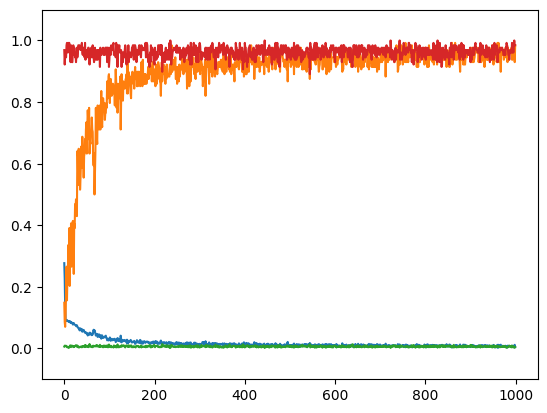

In [26]:
#input and output are fixed for this training data.
#hidden sizes can be changed.
hidden_sizes = [512,128,128]
#64x64 pixels = 784 pixels when flattened out
input_size = 784
#one output neuron for each digit 0-9
output_size = 10
np.random.seed(777)

params = get_params(input_size,hidden_sizes,output_size,fan_init)

#batch size
BS = 128
#learning rate hard to get right
lr = 0.001
iterations=1000

#hyper parameters control how parameters are trained.
hyperparams = [lr,BS,iterations]

#two iterations of 1000 batches
for i in range(2):
    train(params,hyperparams)
    
    print(f'accuracy on test data is {round(numpy_eval(params),4)*100}%')
    #decrease learning rate as model trains.
    #at start of training, we need to change parameters a lot.
    #then towards the end it is more finetuning.
    hyperparams[0]*=0.1

In [20]:

print(f'accuracy on test data is {round(numpy_eval(params),4)*100}%')


accuracy on test data is 96.37%


Predicted value is : 6, this is correct!


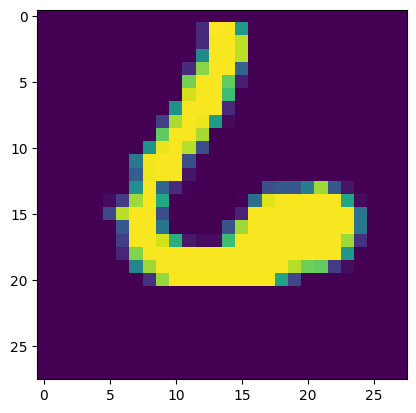

In [7]:
samp = np.random.randint(0, X_test.shape[0], size=(1))
img = X_test[samp]
y = np.argmax(forward(img.reshape((-1,28*28)),params))
print(f'Predicted value is : {y}, this is {["wrong.","correct!"][int(Y_test[samp][0]==y)]}')
plt.imshow(img[0], interpolation='nearest')
plt.show()


